# Plasma Dynamics and Diagnostics of Eruptive Solar Prominences

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits # allows one to access both data and header of FITS files.
from astropy.wcs import WCS # allows to use Wor§ld Coords System
import jupyterlab
#from iris_lmsalpy import hcr2fits

In [37]:
import astropy
import json
import matplotlib
import numpy
import requests
import os
import traceback
import PyQt5
import pyqtgraph

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # this makes the Jupyter notbook wider

C:\Users\chiar\AppData\Local\Temp\ipykernel_7880\3398558441.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


``#The following code should download the prominence data
import hcr2fits
query_text = 'https://www.lmsal.com/hek/hcr?cmd=search-events3&outputformat=json&startTime=2014-05-28T11:24&stopTime=2014-05-28T16:00&hasData=true&limit=200'
list_urls = hcr2fits.get_fits(query_text, sji_only=False, decompress=False)# can set decompress=True if you're able to install gunzip``

In [6]:
# Set up default matplotlib options
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'viridis'

### Import SJI

First of all, the prominence data needs to be imported. It is in 'FITS' format. 3 files are loaded: the first object contains the science data and header, while the other two contain auxiliary metadata.      
`sji[0].header['name of header']` should access the info for that header.    
`sji[0].data` should instead access the data, which had three dimentions: x, y and time (ordered as time, y, x).
`sji[0].data[0]` is the first timestep.

In [7]:
# do_not_scale_image_data = True scales the values from (0-255) values to DN units

sji = fits.open("clean_iris_l2_20140528_112458_3820111493_SJI_2796_t000_cleaned.fits", do_not_scale_image_data=True) # NON-SCALED DATA: values between 0 and 255, integers
#sji = fits.open("clean_iris_l2_20140528_112458_3820111493_SJI_2796_t000_cleaned.fits", do_not_scale_image_data=False) # SCALED DATA: intensity in DN units

# some useful headers:
print(sji[0].header['FOVX']) # Field of view in x-direction (in arcsec)
print(sji[0].header['FOVY']) # Field of view in y-direction (in arcsec)
print(sji[0].header['DSUN_OBS']) # Distance from IRIS to Sun center; level 2: most common value of l1.5 files
print(sji[0].header['CDELT1']) # Image scale in the CCD x direction
print(sji[0].header['CDELT2']) # Image scale in the CCD y direction
print(sji[0].header['CDELT3']) # level 2: image scale in z direction (raster: scale in solar x-direction, SJI: mean time difference between images)
#sji[0].header

231.892
182.32
151602000000.0
0.3327
0.3327
32.4842


In [8]:
# the data types of scaled and non-scaled images is different:
print(sji[0].data[0].dtype)

# Conversion from one to the other is given by:
print(sji[0].data[0][200,301]) # storage value (0-255)
#print(sji2[0].data[0][200,301]) # DN units
a = sji[0].data[0]*sji[0].header['BSCALE']+sji[0].header['BZERO'] # storage value * Bscale + Bzero = DN units value
print(a[200,301])

uint8
21
7997.25


(511, 548, 697)


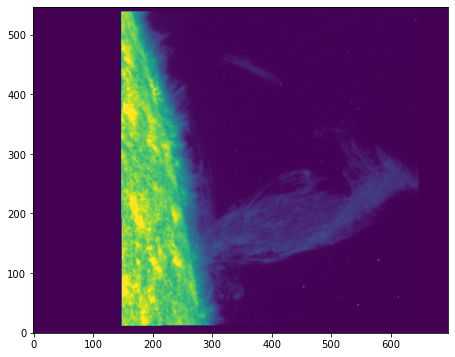

In [9]:
hd = sji[0].header #otherwise use this to put into DN units and scale
plt.imshow(sji[0].data[440], vmin=0, vmax=200)
print(sji[0].data.shape)
plt.savefig('image p')
plt.show()

We can use WCS to add helioprojective coordinates and we can also add the slit position on top of this image. We open the second sji file, with the auxiliary metadata. 
`sji[1].data.shape()` reveals this has size (80, 31) where the dimensions are time and different variables. SLTPX1IX (index=4) is the slit's x coordinate, and it moves with time

  'seconds' -> 's'. [astropy.wcs.wcs]


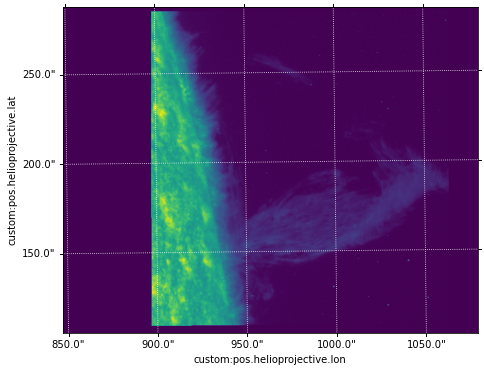

In [11]:
from astropy.wcs import WCS # to plot helioprojective coordinates

wcs = WCS(hd) # this allows us to plot the image using real solar x and y coords
ax = plt.subplot(projection=wcs.dropaxis(-1)) # we drop the last axis i.e. the time one
ax.imshow(sji[0].data[440] * sji[0].header['BSCALE']+sji[0].header['BZERO'])#, vmin=0, vmax=100)
ax.coords[0].set_major_formatter('s.s') # we do this so we can have units of arcsec and not degrees or minutes
ax.coords[1].set_major_formatter('s.s')
ax.grid(color='w', ls=':') #simply adds a grid to the plot
#plt.axvline(x=sji[0].data[440, 4], color='black') # add vertical line at chosen timestep

## Plasma Tracking with Optical Flow

In [12]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [13]:
# opencv needs to be installed on anaconda
import cv2 # this is the module we need for Optical flow 
import time
import pylab as pl
from IPython import display # for plotting in for loop

We need to determine the total number of SJI images we have. It should be noted that the last SJI image is empty, and therefore it should be discarded.  
All SJI images are put into the SJIimages array.

In [14]:
print('The total number of SJI images is: {0}'.format(len(sji[0].data)))
SJIimages = [] #this list will contain all the SJI images we have 
for i in range(0, len(sji[0].data)-1):
    SJIimages.append(sji[0].data[i])

SJIimages = np.array(SJIimages) # turn this from list to array

The total number of SJI images is: 511


### Preparing the SJI images

Before Optical Flow is applied to the images, we need to make sure that:  
    - the solar disk and outer FOV of image are removed ?   
    - images are in greyscale (they can be converted using `cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)`). [As it turns out, the images are already in grey scale]

In [15]:
print(sji[0].data[0].shape) #we want to check if image is in grey scale

if len(sji[0].data[0].shape) == 2:
    print('The image is in grayscale, no need to convert it :)')
else:
    print('Image in not in grayscale, needs conversion :(')

(548, 697)
The image is in grayscale, no need to convert it :)


As it can be seen, from the plotted SJI images, only part of of the prominence is always visible. The top part of the structure is instead only visible in the last few SJI images of every scan. 

In [16]:
SJIimages_centre = []
SJIimages_top = []
print(sji[0].data.shape)
print(sji[0].data[4][20:300,300:500].shape)

for i in range(0, len(SJIimages)+1):
    SJIimages_centre.append(sji[0].data[i][20:300,300:500])
    
for i in range(31, len(SJIimages), 32):
    SJIimages_top.append(sji[0].data[i][20:300,500:-1])

print(SJIimages_centre[0].shape, SJIimages_top[0].shape)

(511, 548, 697)
(280, 200)
(280, 200) (280, 196)


#### Normalisation:  
when using data that was not scaled into DN units while being imported, normalisation isn't necessary. The values of the pixel intensities are integer numbers between 0 and 255. Hence, the images have dtype 'UINT8', and optical flow should work best with them.   
Still, we can clip high values (e.g. I > 200) out and remove hot pixels, so that, when visualising the prominence, the intensity of the images doesnt't vary so much.

In [17]:
# NumPy provides numpy.interp for 1-dimensional linear interpolation.
# In this case, where you want to map the minimum element of the array to −1 and the maximum to +1, and other elements linearly in-between, you can write:

#SJIimages_centre = np.interp(SJIimages_centre, (np.min(SJIimages_centre), np.max(SJIimages_centre)), (0,255))
#SJIimages_top = np.interp(SJIimages_top, (np.min(SJIimages_top), np.max(SJIimages_top)), (0,255))

SJIimages_c_clipped = np.clip(SJIimages_centre, 0, 80, None)
SJIimages_t_clipped = np.clip(SJIimages_top, 0, 80, None)

print(SJIimages_centre[0])
print(SJIimages_centre[1].dtype)

[[47 46 41 ...  0  1  2]
 [48 45 43 ...  0  1  1]
 [48 46 42 ...  2  0  2]
 ...
 [ 4  5  6 ...  2  1  1]
 [ 3  4  5 ...  2  2  1]
 [ 3  3  4 ...  1  1  1]]
uint8


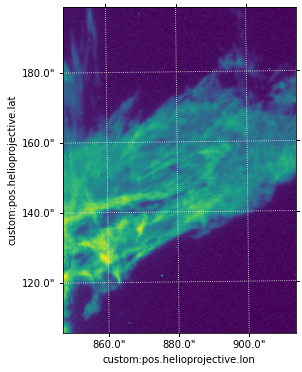

In [18]:
ax = plt.subplot(projection=wcs.dropaxis(-1)) # we drop the last axis i.e. the time one
ax.imshow(SJIimages_centre[40]* sji[0].header['BSCALE']+sji[0].header['BZERO'])#, vmin=0, vmax=100)
#ax.imshow(np.log10(sji2[0].data[0]))
print()
ax.coords[0].set_major_formatter('s.s') # we do this so we can have units of arcsec and not degrees or minutes
ax.coords[1].set_major_formatter('s.s')
ax.grid(color='w', ls=':') #simply adds a grid to the plot

From pixel units to km:

In [19]:
# Convertig from pixel units to km
alpha_arcsec = sji[0].header['CDELT1'] # this is the same in both x and y directions
alpha_rad = alpha_arcsec*np.pi/(3600*180)
Sun_distance_km = sji[0].header['DSUN_OBS']/1000
pixel_km = alpha_rad/2*Sun_distance_km # np.tan(alpha_rad/2)*Sun_distance_km
time = sji[0].header['CDELT3']
print(pixel_km,time)
print(alpha_arcsec)

122.26512684761516 32.4842
0.3327


### Applying Farneback's Optical Flow

The OpenCv Optical Flow algorithm is now applied to the central part of the prominence.  
The algorithm takes in an image, the following image and some parameters. It outputs the x and y components of the vectors describing the motion of each pixel.

Default parameters:  
- image scale to build pyramids for each scale: 0.5 (each next layer is twice smaller than previous one?  
- number of pyramid layers: 3 (if 1 no extra layers are created, only original images are used)  
- averaging window size: 15 (larger values = more robust to noise but more blurred field (good for fast motion))  
- iterations: 3 (iterations at each pyramid level)  
- poly\_n: 5 (size of pixel neighbourhood used for poly expansion: higher number means blurred motion field)  
- ply\_sigma: 1.2 SD of Gaussian for smoothing derivative used for ply expansion  
- flags: 0   

The motion vectors are then visualised with plt.quiver, in which the colorbar displays the velocity values calculate in km/s.

In [20]:
print(SJIimages_centre[0].shape)

(280, 200)


We now apply OF to all images, and show plots to see the prominence's motion. 

In [21]:
lat_prominence = 10/360*2*np.pi
inclination = 30/360*2*np.pi

In [ ]:
stepsize = 1
step = 3
MAGNITUDES = []
MAGNITUDES_rad = []
ANGLES = []
#POS_x = []
#POS_y = []

for i in range(40, len(SJIimages_centre)-3, stepsize):
    display.clear_output(wait=True) # this allows to update the plot
    magnitudes = []
    
    #previous = SJIimages_centre[i]
    previous = SJIimages_centre[i]
    nextone = SJIimages_centre[i+stepsize]
    flow_c = cv2.calcOpticalFlowFarneback(previous, nextone, None, 0.5, 4, 20, 4, 5, 1.5, 0)
    #plt.ion()
    # set colour of arrows = velocity in km/s:
    #colour_c = np.sqrt(flow_c[::step, ::step, 0]**2 + flow_c[::step, ::step, 1]**2)*pixel_km/(32.4842*stepsize)
    mag, ang = cv2.cartToPolar(flow_c[::step, ::step, 0],flow_c[::step, ::step, 1])
    colour_c = mag*pixel_km/(32.4842*stepsize)
    
        
    # set x_c and y_c components = 0 if the pixel intensity is below or above a certain threshold
    I_max = np.max(SJIimages_centre[i])
    I_min = np.min(SJIimages_centre[i])
    I_threshold = (I_min + (I_max-I_min)*0.15)

    
    rows, columns =  SJIimages_centre[i].shape
    for j in range(0,rows):
        for k in range(0,columns):
            if SJIimages_centre[i][j,k] < I_threshold: # if value of pixel is below a certain threshold
                flow_c[j,k,0] = 0    # the components of the flow vectors for that pixel are set to zero
                flow_c[j,k,1] = 0
    
    
    # The following code sets colour = 0 for pixels below a certain intensity threshold. This way the colorbar only 
    # displays values corresponding to the arrows on the prominence.
    a = np.arange(0, rows, step)
    b = np.arange(0, columns, step)
    for j in a:
        for k in b:
            if SJIimages_centre[i][j,k] < I_threshold:
                colour_c[int(j/step),int(k/step)] = 0   
            else:
                MAGNITUDES.append(colour_c[int(j/step),int(k/step)])
                ANGLES.append(ang[int(j/step),int(k/step)])
                #print(j/3, k/3) # these should be integers
                
    #To extract x and y velocity values into two arrays:            
    #print(flow_c.shape,flow_c[1].shape, colour_c.shape)
    #POS_x.append(flow_c[:, :, 0])
    #POS_y.append(flow_c[:, :, 1]) 
    
    
#    c = np.arange(0, colour_c.shape[0])
#    d = np.arange(0, colour_c.shape[1])
#    for j in c:
#        for k in d:
#            if colour_c[j,k] == 0.00:
#                pass
#            else:
#                3dmag.append()
#                MAGNITUDES.append(colour_c[j,k])
    
    #plotting 
    plt.figure(figsize=[26,28])
    plt.subplot(221)
    plt.title("Plot of POS velocities between {0}th and {1}th SJI images".format(i, i+stepsize), fontsize=14)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('off')
    plt.quiver(np.arange(0, flow_c.shape[1], step), np.arange(0, flow_c.shape[0], step), 
               flow_c[::step, ::step, 0], flow_c[::step, ::step, 1], colour_c, cmap= 'plasma')# scale = 0.01, scale_units='xy')
    clb1 = plt.colorbar(shrink=1)
    #clb1.set_label('velocity \n(km/s)', labelpad=-40, y=1.05, rotation=0, fontsize= 14)
    clb1.set_label('velocity (km/s)', fontsize= 14)
    plt.imshow(SJIimages_c_clipped[i], origin='lower', cmap='Blues') # image of the prominence under quiver 
    if i == 59:
        plt.savefig('tracking.png', format='png', bbox_inches='tight')
    else:
        pass
    plt.subplot(222)
    plt.title('{0}th normalised SJI image'.format(i))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(SJIimages_c_clipped[i], cmap='Blues') 
    clb2 = plt.colorbar(shrink=0.9)
    clb2.set_label('Intensity \nof pixel',labelpad=-40, y= 1.05, rotation=0)
    plt.show()
    

    plt.pause(1)

Once optical flow has been applied to the prominence, we have thousands of velocity vectors describing the velocities of the prominence. We can see how velocity magnitudes are distributed by plotting historgrams.

In [ ]:
#Plot histogram of all velocity values calculated:
import seaborn as sns

M = (np.array(MAGNITUDES)).flatten()

#print('v_max = {0:.3f} and v_min = {1}'.format(np.max(MAGNITUDES), np.min(MAGNITUDES)))

plt.figure(figsize=[14,10])
sns.displot(data=M, binwidth=0.2, x=None, y=None, hue=None, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None,
            hue_order=None, hue_norm=None, color=(0.2,0,0.9), col_wrap=None, row_order=None, col_order=None, height=7, aspect=2, facet_kws=None)
plt.xlim(0, 9)
#plt.ylim(0, 2*10**6)
plt.xticks(range(0,8),fontsize = 18)
plt.yticks((0,50000,100000,150000),fontsize = 18)
#plt.title('Plane-of-Sky Velocities from SJI analysis', fontsize=14)
plt.xlabel('POS velocity (km/s)', fontsize = 18)
plt.ylabel('Number of velocity vectors', fontsize = 18)
#plt.grid()
plt.show()

### Finding radial velocities

In [ ]:
#print(ANGLES.shape)
MAGNITUDES = np.array(MAGNITUDES)
ANGLES = np.array(ANGLES)
#MAGNITUDES_rad = []
#for i in range(40, len(SJIimages_centre)):
MAGNITUDES_rad = MAGNITUDES/np.cos(inclination)*(np.cos(ANGLES-np.full(1041045, lat_prominence)))

In [ ]:
M_rad = (np.array(MAGNITUDES_rad)).flatten()

#print('v_max = {0:.3f} and v_min = {1}'.format(np.max(MAGNITUDES), np.min(MAGNITUDES)))

plt.figure(figsize=[12,8])
sns.displot(data=M_rad, binwidth=0.2, x=None, y=None, hue=None, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None,
            hue_order=None, hue_norm=None, color=None, col_wrap=None, row_order=None, col_order=None, height=7, aspect=2, facet_kws=None)
plt.xlim(0, 10)
#plt.ylim(0, 2*10**6)
plt.xticks(range(0,11))
plt.title('Velocities distribution')
plt.grid()
plt.show()

#### Streamplot:

### Top of the prominence
The tracking with optical flow is repeated for the top of the prominence. This region of the prominence is only visible in the last few SJI images of every scan. Hence, we took the last image of each scan and applied optical flow between them. The optical flow algorithm now needs to calculate motion vectors between images separated by a longer time period (= time of one scan = ?).

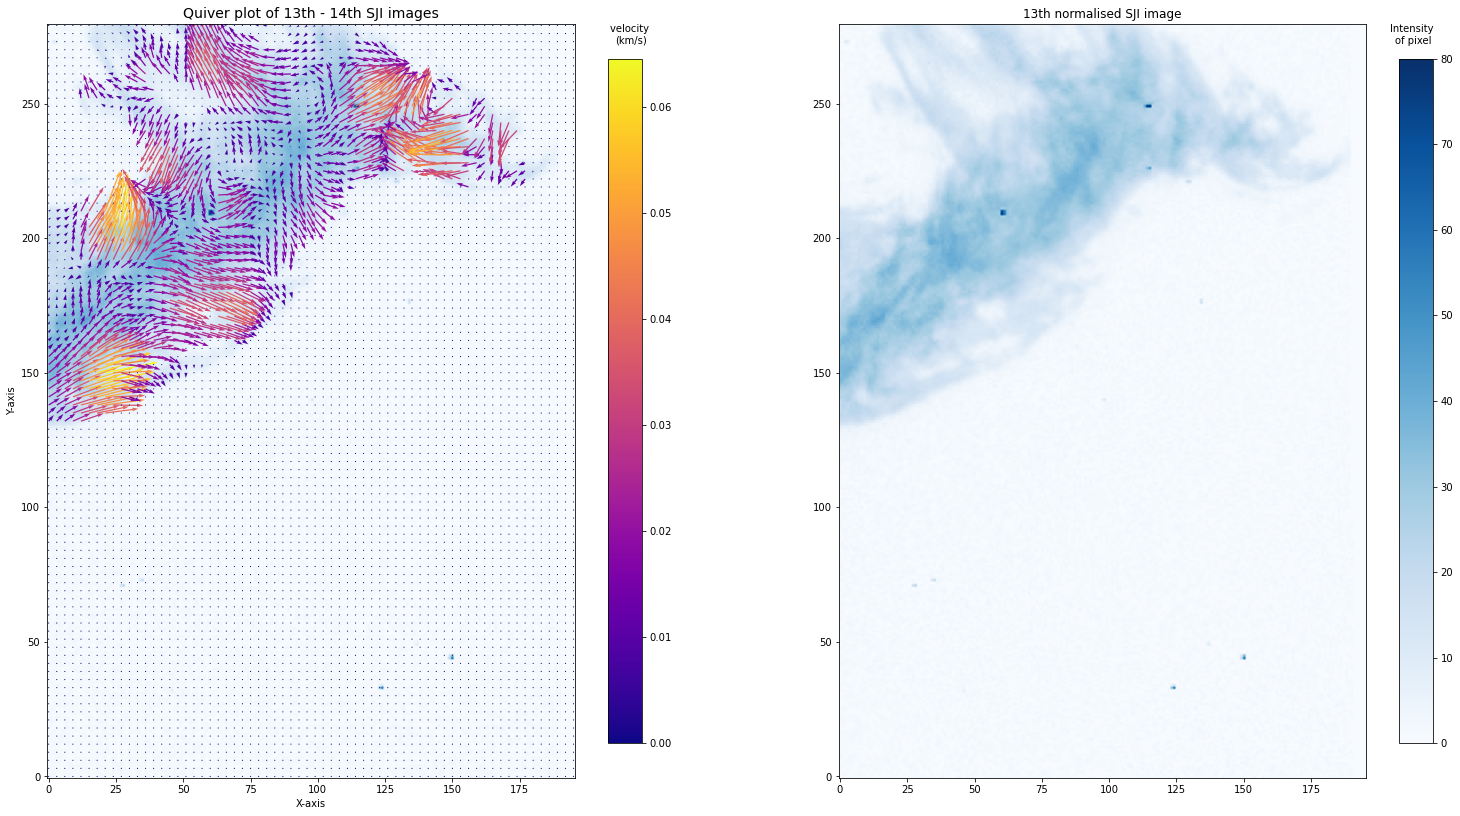

In [35]:
# Non-normalised images

stepsize = 1
MAGNITUDES_T = []

for i in range(0, len(SJIimages_top)-1):
    display.clear_output(wait=True) # this allows to update the plot
    flow_t = cv2.calcOpticalFlowFarneback(SJIimages_top[i], SJIimages_top[i+stepsize], None, 0.5, 4, 30, 4, 7, 1.5, 0)
    plt.ion()
    colour_t = np.sqrt(flow_t[::step, ::step, 0]**2 + flow_t[::step, ::step, 1]**2)*pixel_km/(32*32.4842*stepsize)
    
    # set x_c and y_c components = 0 if the pixel intensity is below a certain threshold (this way only the prominence is tracked)
    I_max = np.max(SJIimages_top[i])
    I_min = np.min(SJIimages_top[i])
    I_threshold = I_min + (I_max-I_min)*0.1

    rows, columns =  SJIimages_top[i].shape
    for j in range(0,rows):
        for k in range(0,columns):
            if SJIimages_top[i][j,k] < I_threshold:#I_threshold:  # if value of pixel is below? a certain threshold
                flow_t[j,k,0] = 0    # the components of the flow vectors for that pixel are set to zero
                flow_t[j,k,1] = 0
    

    a = np.arange(0, rows, step)
    b = np.arange(0, columns, step)
    for j in a:
        for k in b:
            if SJIimages_top[i][j,k] < I_threshold:
                colour_t[int(j/step),int(k/step)] = 0
            else:
                MAGNITUDES_T.append(colour_t[int(j/step),int(k/step)])
    
    # plotting   
    plt.figure(figsize=[26,14])
    plt.subplot(121)
    plt.title("Quiver plot of {0}th - {1}th SJI images".format(i, i+stepsize), fontsize=14)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.quiver(np.arange(0, flow_t.shape[1], step), np.arange(0, flow_t.shape[0], step), 
               flow_t[::step, ::step, 0], flow_t[::step, ::step, 1], colour_t, cmap='plasma')
    clb1 = plt.colorbar(shrink=0.9)
    clb1.set_label('velocity \n(km/s)', labelpad=-40, y=1.05, rotation=0)
    plt.imshow(SJIimages_t_clipped[i], origin='lower', cmap='Blues') # image of the prominence under quiver 
    
    plt.subplot(122)
    plt.title('{0}th normalised SJI image'.format(i))
    plt.imshow(SJIimages_t_clipped[i], cmap='Blues') 
    clb2 = plt.colorbar(shrink=0.9)
    clb2.set_label('Intensity \nof pixel',labelpad=-40, y= 1.05, rotation=0)
    plt.show()

### Distribution of velocities:

for i in range(0, len(MAGNITUDES_T)):
    display.clear_output(wait=True) # this allows to update the plot
    M_T = MAGNITUDES_T[i].flatten()
    sns.displot(data=M_T, binwidth=0.2, x=None, y=None, hue=None, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None,
            hue_order=None, hue_norm=None, color=None, col_wrap=None, row_order=None, col_order=None, height=7, aspect=2, facet_kws=None)
    plt.xlim(0, 3)
    plt.ylim(0, 10)
    plt.title('Velocities between SJI images {0} and {1}'.format((i*stepsize), (i*stepsize)+stepsize))
    plt.grid()
    plt.show()
    
    plt.pause(1)

v_max = 0.439 and v_min = 1.7771507145880605e-06


<Figure size 864x576 with 0 Axes>

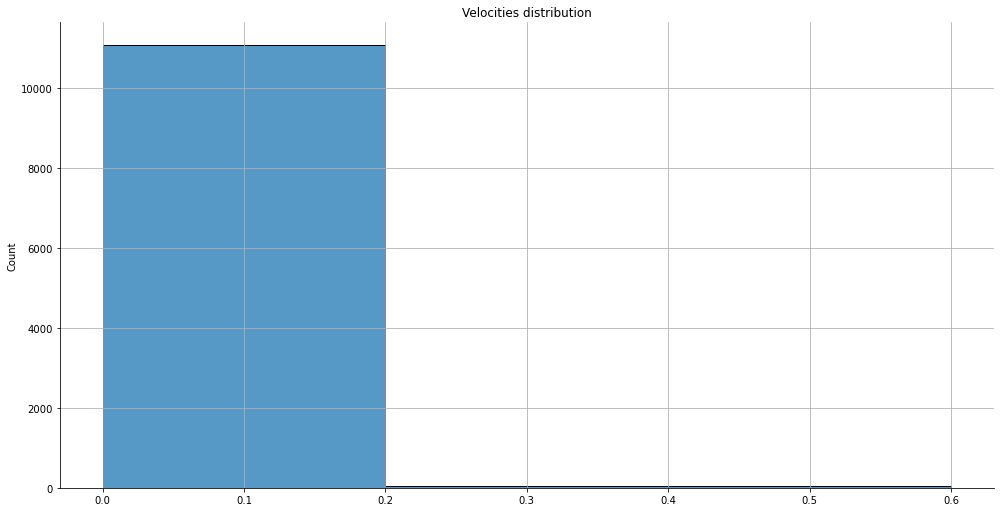

In [27]:
#Plot histogram of all velocity values calculated:

M_T = (np.array(MAGNITUDES_T)).flatten()

print('v_max = {0:.3f} and v_min = {1}'.format(np.max(MAGNITUDES_T), np.min(MAGNITUDES_T)))

plt.figure(figsize=[12,8])
sns.displot(data=M_T, binwidth=0.2, x=None, y=None, hue=None, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None,
            hue_order=None, hue_norm=None, color=None, col_wrap=None, row_order=None, col_order=None, height=7, aspect=2, facet_kws=None)
#plt.xlim(0, 4)
#plt.ylim(0, 2*10**6)
plt.title('Velocities distribution')
plt.grid()
plt.show()

#### Verifying the results by tracking by eye (unsuccessful)

We need to cut the images so that only a small part of the prominence is visible. Then, the movement of the visible features are tracked by eye over a short period of time, to see if the velocities are comparable to the ones obtained trhough optical flow.

In [28]:
SJIv_test = []
for i in range(0, len(SJIimages)+1):
    SJIv_test.append(sji[0].data[i][80:170,330:400])

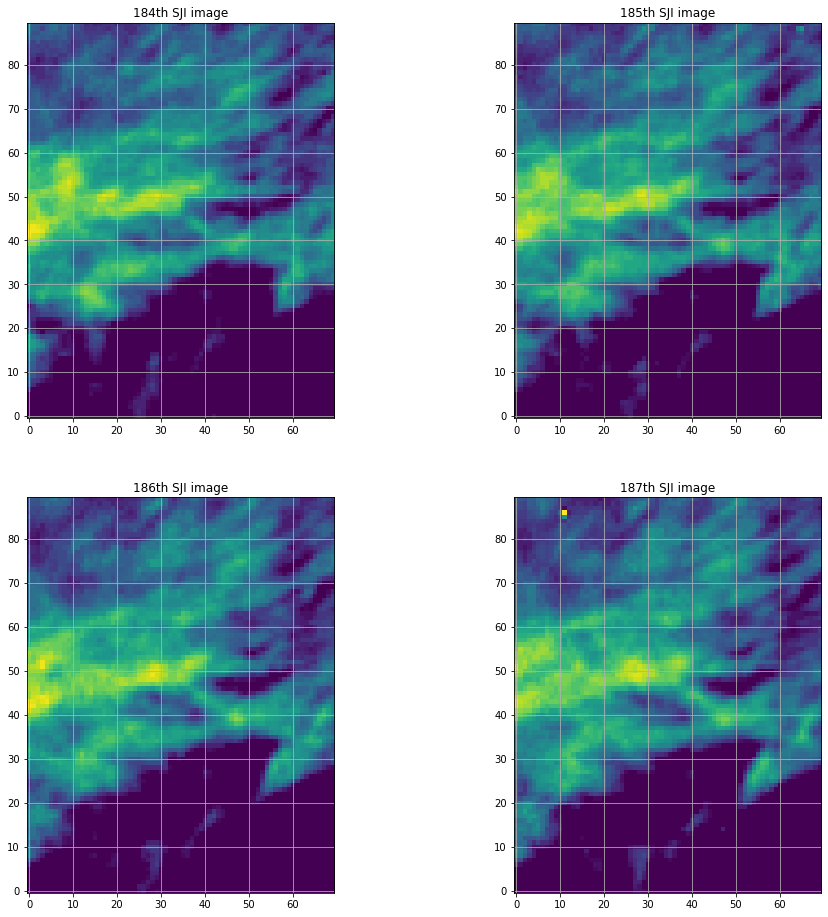

In [29]:
fig = plt.figure(figsize=[16,16])

time = 184

plt.subplot(221)
plt.title('{0}th SJI image'.format(time))
plt.imshow(SJIv_test[time], vmin= 20, vmax= 60)
plt.grid()

plt.subplot(222)
plt.title('{0}th SJI image'.format(time+1))
plt.imshow(SJIv_test[time+1], vmin= 20, vmax= 60)
plt.grid()

plt.subplot(223)
plt.title('{0}th SJI image'.format(time+2))
plt.imshow(SJIv_test[time+2], vmin= 20, vmax= 60)
plt.grid()

plt.subplot(224)
plt.title('{0}th SJI image'.format(time+3))
plt.imshow(SJIv_test[time+3], vmin= 20, vmax= 60)
plt.grid()
plt.show()

In [30]:
# 184 to 185
print(np.sqrt((56-55)**2+(24-23)**2)*pixel_km/(32.4842))
# 158 to 186
print(np.sqrt((55-53)**2+(23-23)**2)*pixel_km/(32.4842))
# 186 to 187
print(np.sqrt((54-53)**2+(23-21)**2)*pixel_km/(32.4842))

5.322864672461202
7.527667410471254
8.416188020911768


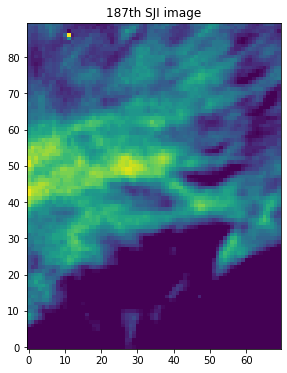

In [31]:
for i in range(184, 188):
    display.clear_output(wait=True)
    plt.title('{0}th SJI image'.format(i))
    plt.imshow(SJIv_test[i], vmin= 20, vmax= 60)
    plt.show()
    
    plt.pause(1.5)

In [32]:
pixel_km/(32.4842)

3.763833705235627

In [33]:
SJIv_test2 = []
for i in range(0, len(SJIimages)+1):
    SJIv_test2.append(sji[0].data[i][90:140,360:400])

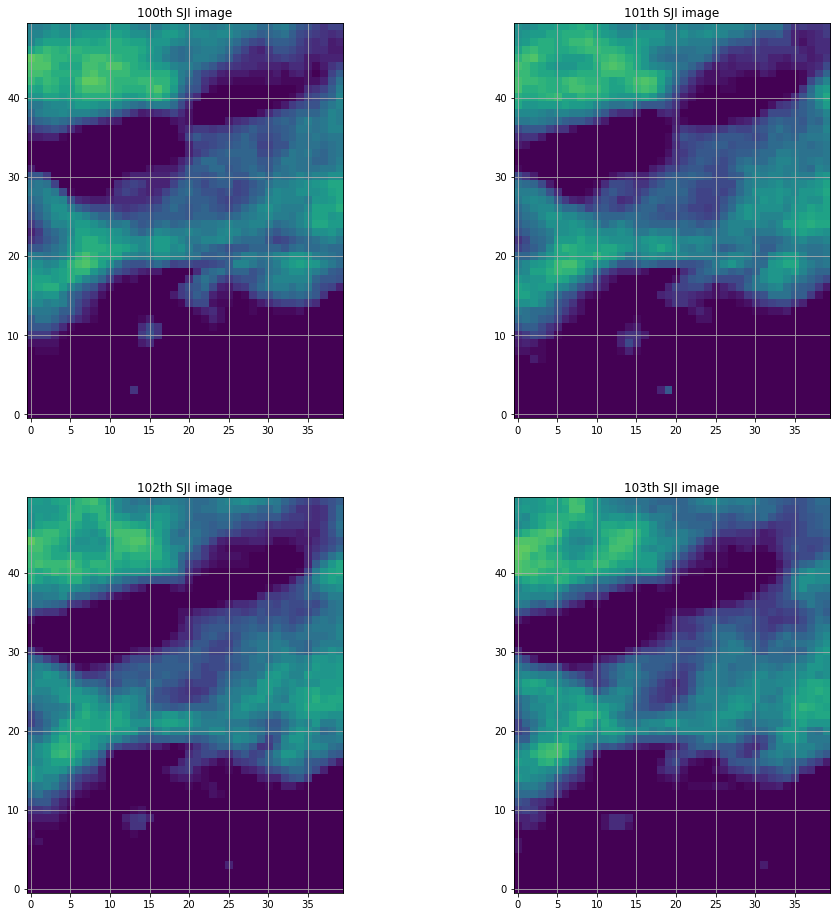

In [34]:
fig = plt.figure(figsize=[16,16])

time = 100

plt.subplot(221)
plt.title('{0}th SJI image'.format(time))
plt.imshow(SJIv_test2[time], vmin= 20, vmax= 60)
plt.grid()

plt.subplot(222)
plt.title('{0}th SJI image'.format(time+1))
plt.imshow(SJIv_test2[time+1], vmin= 20, vmax= 60)
plt.grid()

plt.subplot(223)
plt.title('{0}th SJI image'.format(time+2))
plt.imshow(SJIv_test2[time+2], vmin= 20, vmax= 60)
plt.grid()

plt.subplot(224)
plt.title('{0}th SJI image'.format(time+3))
plt.imshow(SJIv_test2[time+3], vmin= 20, vmax= 60)
plt.grid()
plt.show()

#### Using a video of the prominence (this method was not applied)

Videos of the prominence are created by putting together IRIS SJI images. This will allow to run Optical Flow on different frames of the video, and not just on consecutive images. This was done because most of the implementations of Optical Flow I found work with videos, and not images.

#This is an attempt to turn the SJI images into a video

    import matplotlib.cm as cm
    import matplotlib.animation as animation

    # some array of images
    frames = [] # for storing the generated images
    fig = plt.figure()
    for i in range(0, len(SJIimages)):
        frames.append([plt.imshow(SJIimages[i], cmap = 'gray', animated=True)])

    animation = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)

    #writergif = animation.PillowWriter(fps=30)
    #ani.save('prominence_movie.mp4',writer=writergif)

    plt.rcParams['animation.ffmpeg_path'] ='C:\\Users\\chiara\\Desktop\\ffmpeg.exe'
    #FFwriter = animation.FFMpegWriter()
    animation.save('full_images_clean.avi')#, writer = FFwriter)
    #plt.rcParams['animation.ffmpeg_path'] ='E:\\Media\\ffmpeg\\bin\\ffmpeg.exe'
    #FFwriter = animation.FFMpegWriter()
    #ani.save('basic_animation.mp4', writer = FFwriter, fps=30)

The following code is meant to define functions to visualise Optical Flow between the different images in the video we created:

    # a few functions meant to be used to visualise the Optical flow

    def draw_flow(img, flow, step=16):   
        h, w = img.shape[:2]
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        fx, fy = flow[y,x].T
        lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.polylines(vis, lines, 0, (0, 255, 0))
        for (x1, y1), (_x2, _y2) in lines:
            cv.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
        return vis


    def draw_hsv(flow):  # this is already in the code
        h, w = flow.shape[:2]
        fx, fy = flow[:,:,0], flow[:,:,1]
        ang = np.arctan2(fy, fx) + np.pi
        v = np.sqrt(fx*fx+fy*fy)
        hsv = np.zeros((h, w, 3), np.uint8)
        hsv[...,0] = ang*(180/np.pi/2)
        hsv[...,1] = 255
        hsv[...,2] = np.minimum(v*4, 255)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        return bgr


    def warp_flow(img, flow):
        h, w = flow.shape[:2]
        flow = -flow
        flow[:,:,0] += np.arange(w)
        flow[:,:,1] += np.arange(h)[:,np.newaxis]
        res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
        return res

    # <script src="https://gist.github.com/mpeven/7df30dda0b780a0cfe7f664e5a4d8301.js"></script>
    def put_optical_flow_arrows_on_image(image, optical_flow_image, threshold=5, skip_amount=30):
        # Don't affect original image
        image = image.copy()
    
    # Turn grayscale to rgb if needed
    if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=2)
    
    # Get start and end coordinates of the optical flow
    flow_start = np.stack(np.meshgrid(range(optical_flow_image.shape[1]), range(optical_flow_image.shape[0])), 2) # initial point
    flow_end = (optical_flow_image[flow_start[:,:,1],flow_start[:,:,0],:1]*3 + flow_start).astype(np.int32) #initial point + vector coords = end point
    

    # Threshold values
    norm = np.linalg.norm(flow_end - flow_start, axis=2) # returns norm of give vector
    norm[norm < threshold] = 0  # if the norm of the vector is below a certain threshold, it is set to zero
    
    # Draw all the nonzero values
    nz = np.nonzero(norm) # Return the indices of the elements that are non-zero in norm
    for i in range(0, len(nz[0]), skip_amount): # skip_amount: only certain arrows are plotted?
        y, x = nz[0][i], nz[1][i] # coords of vectors with non zero norm?
        cv2.arrowedLine(image,#image on which the arrows are to be drawn
                        pt1=tuple(flow_start[y,x]), # first point
                        pt2=tuple(flow_end[y,x]), # end point
                        color=(0, 255, 0), # colour of lines
                        thickness=1, tipLength=.2)
                        
    return image

Apply Optical Flow to a prominence video:

cap = cv2.VideoCapture('C:\\Users\\chiara\\Desktop\\prominence_centre.avi')

ret, frame1 = cap.read()

print(frame1.shape)
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY) # is this conversion necessary since the images are already in greyscale?
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
print(prvs.shape)

while(1):
    ret, frame2 = cap.read()
    if ret == False:  # added this and the following line to the original code so that 
        break         # I don't get an error when the last imageis captured.
    #print(frame2.shape)
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY) 

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 1, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb) # cv2.imshow('window name', image)
    cv2.imshow('arrows', put_optical_flow_arrows_on_image(frame2, flow))
    #cv2.imshow('drawflow', draw_flow(frame1, flow))
    #cv2.imshow('warp', warp_flow(rgb, flow))
    #cv2.imshow('draw_hsv', draw_hsv(flow))
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()